In [2]:
import numpy as np
from glob import glob
import os

path_to_train = 'comp-540-spring-2019/train'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')

train_img_paths = glob(glob_train_imgs)
train_mask_paths = glob(glob_train_masks)

In [3]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

# This will be useful so we can construct the corresponding mask
def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id

# Write it like a normal function
def image_gen(img_paths, img_size=(128, 128)):
    # Iterate over all the image paths
    for img_path in img_paths:
        
        # Construct the corresponding mask path
        img_id = get_img_id(img_path)
        mask_path = os.path.join(path_to_train, img_id + '_msk.png')
        
        # Load the image and mask, and normalize it to 0-1 range
        img = imread(img_path) / 255.
        mask = rgb2gray(imread(mask_path))
        
        # Resize the images
        img = resize(img, img_size, preserve_range=True)
        mask = resize(mask, img_size, mode='constant', preserve_range=True)
        # Turn the mask back into a 0-1 mask
        mask = (mask >= 0.5).astype(float)
        
        # Yield the image mask pair
        yield img, mask

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


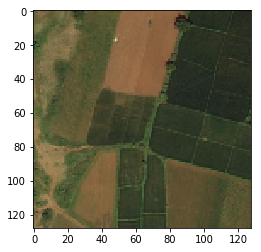

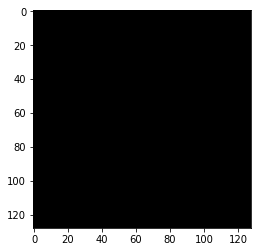

In [7]:
import matplotlib.pyplot as plt


ig = image_gen(train_img_paths)

first_img, first_mask = next(ig)
second_img, second_mask = next(ig)
third_img, third_mask = next(ig)

plt.imshow(second_img)
plt.show()
plt.imshow(second_mask, cmap='gray')
plt.show()

(128, 128, 3)

In [ ]:
# Create simple model
from keras.layers import Conv2D, Reshape
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(64, 5, activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(Conv2D(128, 5, activation='relu', padding='same'))
model.add(Conv2D(1, 5, activation='sigmoid', padding='same'))
model.add(Reshape((128, 128)))

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

SystemError: <class '_frozen_importlib._ModuleLockManager'> returned a result with an error set

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

In [8]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

smooth = 1e-9

# This is the competition metric implemented using Keras
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# We'll construct a Keras Loss that incorporates the DICE score
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1. - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + dice_coef(y_true, y_pred)

model.compile(Adam(lr=0.01), loss=bce_dice_loss, metrics=[dice_coef])

In [9]:
import numpy as np

# Keras takes its input in batches 
# (i.e. a batch size of 32 would correspond to 32 images and 32 masks from the generator)
# The generator should run forever
def image_batch_generator(img_paths, batchsize=32):
    while True:
        ig = image_gen(img_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:
            # Add the image and mask to the batch
            batch_img.append(img)
            batch_mask.append(mask)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
                batch_img, batch_mask = [], []
        
        # If we have an nonempty batch left, yield it out and reset
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
            batch_img, batch_mask = [], []

In [10]:
from sklearn.model_selection import train_test_split

BATCHSIZE = 32

# Split the data into a train and validation set
train_img_paths, val_img_paths = train_test_split(train_img_paths, test_size=0.15)

# Create the train and validation generators
traingen = image_batch_generator(train_img_paths, batchsize=BATCHSIZE)
valgen = image_batch_generator(val_img_paths, batchsize=BATCHSIZE)

def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

# Train the model
history = model.fit_generator(
    traingen, 
    steps_per_epoch=train_steps, 
    epochs=2, # Change this to a larger number to train for longer
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    max_queue_size=5  # Change this number based on memory restrictions
)

Epoch 1/2


/Users/elliot/Library/Python/3.6/lib/python/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/elliot/Library/Python/3.6/lib/python/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


290/290 [==============================] - 2347s 8s/step - loss: 0.3123 - dice_coef: 5.2488e-05 - val_loss: 0.3006 - val_dice_coef: 1.1149e-13
Epoch 2/2
290/290 [==============================] - 2395s 8s/step - loss: 0.3124 - dice_coef: 1.0356e-13 - val_loss: 0.3006 - val_dice_coef: 1.1149e-13


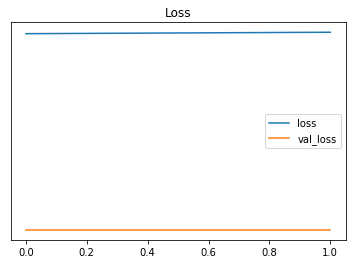

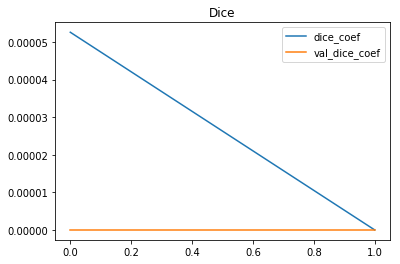

In [11]:
import pandas as pd

# Plot the training curve
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(title="Loss", logy=True)
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot(title="Dice")